In [1]:
import numpy as np
import mne
import pandas as pd
import pylab as plt

# For custom codebase
import sys
sys.path.insert(0, 'C:\\Users\\esolo\\Documents\\Python Scripts\\lib')

# For parallel processing
import multiprocessing as mp
n_cpus = mp.cpu_count()

In [51]:
#np.save('./multitaper_epo_plots/sampleEEG/sub538_coordinates.npy', np.array(mytfr.elecs[['anatX', 'anatY', 'anatZ']]))

In [6]:
from codebase import subject_tfr

mytfr = subject_tfr()
mytfr.load_data_epo('538', 'DLPFC')
mytfr.set_params()
mytfr.n_cpus = 2
mytfr.set_tfr_power()
mytfr.subtract_baseline(100, 225)

Reading D:\538\complete_epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    2000.00 ms
        0 CTF compensation matrices available
Adding metadata with 11 columns
150 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  30 tasks      | elapsed:    2.5s
[Parallel(n_jobs=2)]: Done 138 tasks      | elapsed:   12.2s
[Parallel(n_jobs=2)]: Done 184 out of 184 | elapsed:   15.9s finished


Adding metadata with 11 columns


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  16 tasks      | elapsed:    2.5s
[Parallel(n_jobs=2)]: Done  70 tasks      | elapsed:   11.7s
[Parallel(n_jobs=2)]: Done 160 tasks      | elapsed:   27.5s
[Parallel(n_jobs=2)]: Done 184 out of 184 | elapsed:   31.3s finished


Adding metadata with 11 columns


In [103]:
np.where(np.array(mytfr.epochs.ch_names)=='LFPx180-LFPx181')

(array([154], dtype=int64),)

**Visualize the spectrogram**

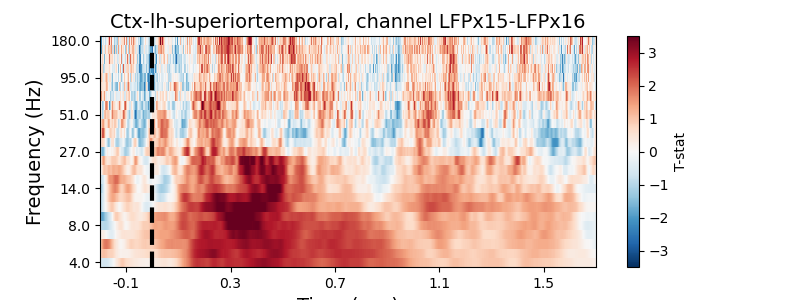

In [18]:
%matplotlib widget 
from codebase import filter_dict

# Plot TFR
e = 8
mytfr.set_t_statistic(e=e)
#mytfr.plot_tfr(data=np.mean(mytfr.tfr_sham[:, e, :, :], axis=0), figsize=(8, 3),  vmin=-0.25, vmax=0.25)
mytfr.plot_tfr(data=mytfr.t, figsize=(8, 3), vmin=-3.5, vmax=3.5)
plt.title(mytfr.elecs.iloc[e]['DKT_label']+', channel '+str(mytfr.elecs['Channel'].iloc[e]), fontsize=14);
plt.xlim(150, 1100)
plt.savefig('./multitaper_epo_plots/sampleEEG/subject538_electrode8_tstat.pdf')

**Visualize histograms of spectral power**

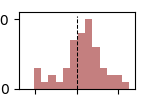

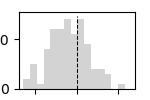

In [43]:
r, col = np.where(mytfr.t==np.max(mytfr.t))
a = mytfr.tfr_tms[:, e, r, col]  #TMS powers across trials
b = mytfr.tfr_sham[:, e, r, col]  # sham powers across trials

plt.figure(figsize=(1.5, 1)); ax=plt.subplot(111)
plt.hist(a, 15, color='darkred', alpha=0.5)
plt.vlines([0], ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], linewidth=0.75, linestyle='--', color='k')
plt.xlim(-1.4, 1.4)
#plt.savefig('./multitaper_epo_plots/sampleEEG/TMS_hist.pdf')

plt.figure(figsize=(1.5, 1)); ax=plt.subplot(111)
plt.hist(b, 15, color='darkgray', alpha=0.5)
plt.vlines([0], ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], linewidth=0.75, linestyle='--', color='k')
plt.xlim(-1.4, 1.4)
#plt.savefig('./multitaper_epo_plots/sampleEEG/sham_hist.pdf')

**Visualize some example traces**

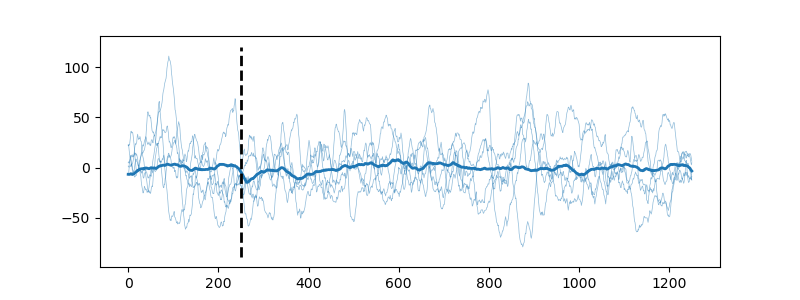

In [387]:
d = mytfr.epochs['sham'].get_data()
plt.figure(figsize=(8, 3)); ax=plt.subplot(111)
plt.plot(d[np.random.randint(0, d.shape[0], size=5), e, :].T, color='C0', linewidth=0.5, alpha=0.5);
plt.plot(np.mean(d[:, e, :], 0), color='C0', linewidth=2,);
plt.vlines([250], ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], linestyle='--', linewidth=2, color='k')

In [421]:
plt.close('all')

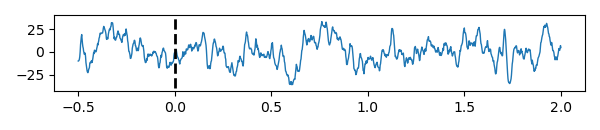

In [423]:
trial = 29
x = (np.arange(0, 1251)/500.)-0.5
plt.figure(figsize=(6, 1.3)); ax=plt.subplot(111)
plt.plot(x, d[trial, e, :].T, color='C0', linewidth=1);
plt.vlines([0], ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], linestyle='--', linewidth=2, color='k')
plt.tight_layout()
#plt.savefig('./multitaper_epo_plots/sampleEEG/sub538_elec8_trial29_sham.pdf')

**Good theta examples:** 
- Subject 538, DLPFC stim, electrode 42 (LFPx79-LFPx80; orbitofrontal depth), trial 27, 32, 44 -- try plotting this one across the whole epoch!
- Subject 538, DLPFC stim, electrode 48, trial 36
- Subject 538, DLPFC stim, electrode 8, trial 3, 9, 8, 25, 32, 22
- Subject 538, DLPFC stim, electrode 118, trial 32, 3, 8, 20, 49, 34, 30, 42
- Subject 538, DLPFC stim, electrode 109, trial 2, 21, 9, 38, 16, 48, 43
- Subject 477, Parietal stim, electrode 132, trial 11, 10, 32, 23, 4, 44
- Subject 404, STG, electrode 24, trial 35
- Subject 634, R_Parietal, electrode 37, trial 20
- Subject 593, L_DLPFC, electrode 60 generally good-looking power and ERP response

### Power across a single sessions

In [13]:
mytfr.epochs

Number of events,150
Events,sham: 100tms: 50
Time range,-0.500 – 2.000 sec
Baseline,off


In [26]:
spectrum = mytfr.epochs.compute_psd(method='multitaper', tmin=0.5, tmax=1.5, fmin=3, fmax=8, n_jobs=8)
psd_pre, freqs_ = spectrum.get_data(return_freqs=True)
psd_pre = np.log10(psd_pre)

    Using multitaper spectrum estimation with 7 DPSS windows


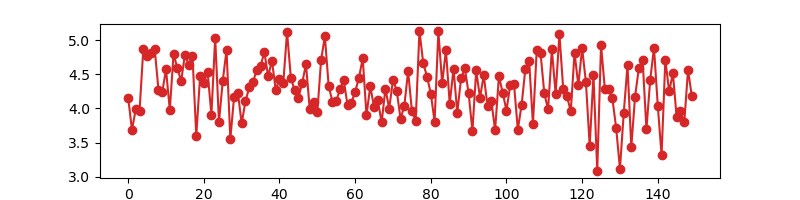

In [32]:
%matplotlib widget
plt.figure(figsize=(8, 2)); ax=plt.subplot(111)
plt.plot(np.mean(psd_[:, 42, :], 1), 'o-', color='C3')